In [1]:
# general imports
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import seaborn as sns
import time
import warnings, logging

# pyspark module
from pyspark.rdd import RDD

# src module
from src.data import get_gm, get_kdd
from src.kmeans.base import compute_cost
from src.kmeans.initialization import kMeansParallel_init, kMeansPlusPlus_init, kMeansRandom_init
from src.kmeans.update import lloydKMeans, miniBatchKMeans
from src.utils import sparkSetup

Starting the cluster

In [2]:
# creating the zipped environment if it doesn't already exist
! if [ ! -f "environment.tar.gz" ]; then venv-pack -o "environment.tar.gz" ; fi
# creating the zipped module src
! if [ -f "src.tar.gz" ]; then rm src.tar.gz ; fi
! tar -czf src.tar.gz src

In [3]:
# starting the cluster
! $SPARK_HOME/sbin/start-all.sh

starting org.apache.spark.deploy.master.Master, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.master.Master-1-mapd-b-14-1.out
worker1: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-2.out
worker3: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-4.out
master: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-1.out
worker2: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-3.out


In [4]:
os.environ["PYSPARK_PYTHON"] = "./environment/bin/python"

In [5]:
# creating a sparkSession
spark = sparkSetup("kMeans")
sc = spark.sparkContext
# exporting the src module
sc.addPyFile("src.tar.gz")
sc.setLogLevel("ERROR")
# Setup the spark warnings
# log4j_conf_path = "./config/log4j.properties"
# warnings.filterwarnings("ignore") 
# logging.getLogger('py4j').setLevel(logging.ERROR) 
# logging.getLogger('pyspark').setLevel(logging.ERROR) 

25/09/15 11:52:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/15 11:52:30 WARN Utils: Untarring behavior will be deprecated at spark.files and SparkContext.addFile. Consider using spark.archives or SparkContext.addArchive instead.


# Load and Test datasets

## Gaussian Mixture

The first dataset we would consider to test the performance of the k-means++ initialization algorithm is a synthetic GaussMixture. To generate it, we sampled $k$ centers from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance $R\in \{1,10,100\}$. We then added points from Gaussian distributions of unit variance around each center. Given the $k$ centers, this is a mixture of $k$ spherical Gaussians with equal weights. The value of the optimal k-clustering
can be well approximated using the centers of these Gaussians.

We will perform some preliminary analysis that can be efficiently conducted on this dataset.

# kMeans|| Init Tests

## Time / Cost tables

The first thing we want to assess with this dataset is the performance in terms of time and cost using different initialization algorithms. In particular, we chose to initialize our k-means algorithm with four different methods:

- **random**;
- **k-means++**;
- **k-means||** with $l\cdot k = 0.5$;
- **k-means||** with $l\cdot k = 2$.

Each initialization method is followed by Lloyd's iterations.

This setup allows us to investigate whether the parallelization introduced by the k-means|| initialization leads to improved clustering performance, using random and k-means++ initializations as baselines.

In [6]:
def compute_initAlgoMetrics(
    initAlgo: str,
    data_ndarray: npt.NDArray, 
    data_rdd: RDD, 
    iterations: int, 
    k: int, 
    l: float, 
    r: int
) -> tuple[float, float, float, float]:
    # Initialization
    startTime = time.time()
    
    if initAlgo == "random": 
        centroids = kMeansRandom_init(data_rdd, k)
    elif initAlgo == "plusplus": 
        centroids = kMeansPlusPlus_init(data_ndarray, k)
    elif initAlgo == "parallel": 
        centroids = kMeansParallel_init(data_rdd, k, l, r)
    else: 
        raise ValueError(f"Wrong initialization algorithm selected: '{initAlgo}'")
         
    initTime = time.time() - startTime
    seedCost = compute_cost(data_rdd, centroids)

    # update centroids
    startTime = time.time()
    finalCentroids = lloydKMeans(data_rdd, centroids, iterations)
    updateTime = time.time() - startTime
    finalCost = compute_cost(data_rdd, finalCentroids)
    
    return initTime, updateTime, seedCost, finalCost

In [7]:
def exp10_cost(cost, frac_digits=2):
    """Return exponent 'a' s.t. cost ~10^a, rounded to 'frac_digits' decimals."""
    return float(np.round(np.log10(float(cost)), frac_digits))

### GM dataset creation

We need to create three different dataset for each value of $R \in \{1, 10, 100\}$.

In [6]:
# --- control parameters ---
k = 50
n = 10_000
dim = 15
R = [1, 10, 100]
r = 5
iterations = 1000
initAlgorithms = ["random", "plusplus", "parallel", "parallel"]
lk_ratios = [0, 0, 0.5, 2]

In [9]:
initAlgoMetrics = []
for variance in R:
    gmData, gmCenters = get_gm(n, k, dim, variance)
    gmData_rdd = sc.parallelize([row for row in gmData], numSlices=16).persist()
    trueCost = compute_cost(gmData_rdd, gmCenters)
    for initAlgo, lk_ratio in zip(initAlgorithms, lk_ratios):
        print(f"R: {variance} | initAlgo: {f"{initAlgo}{lk_ratio}" if initAlgo == "parallel" else initAlgo}")
        initTime, updateTime, seedCost, finalCost = compute_initAlgoMetrics(
            initAlgo = initAlgo,
            data_ndarray = gmData,
            data_rdd = gmData_rdd,
            iterations = iterations,
            k = k,
            l = lk_ratio * k,
            r = r
        )
        initAlgoMetrics.append({
            "R": variance,
            "initAlgo": f"{initAlgo}{lk_ratio}" if initAlgo == "parallel" else initAlgo,
            "initTime": initTime,
            "updateTime": updateTime,
            "seedCost": seedCost,
            "finalCost": finalCost,
            "trueCost": trueCost
        })
    gmData_rdd.unpersist()

initAlgoMetrics = pd.DataFrame(initAlgoMetrics)

R: 1 | initAlgo: random


R: 1 | initAlgo: plusplus


R: 1 | initAlgo: parallel0.5


R: 1 | initAlgo: parallel2


R: 10 | initAlgo: random


R: 10 | initAlgo: plusplus


R: 10 | initAlgo: parallel0.5


R: 10 | initAlgo: parallel2


R: 100 | initAlgo: random


R: 100 | initAlgo: plusplus


R: 100 | initAlgo: parallel0.5


R: 100 | initAlgo: parallel2


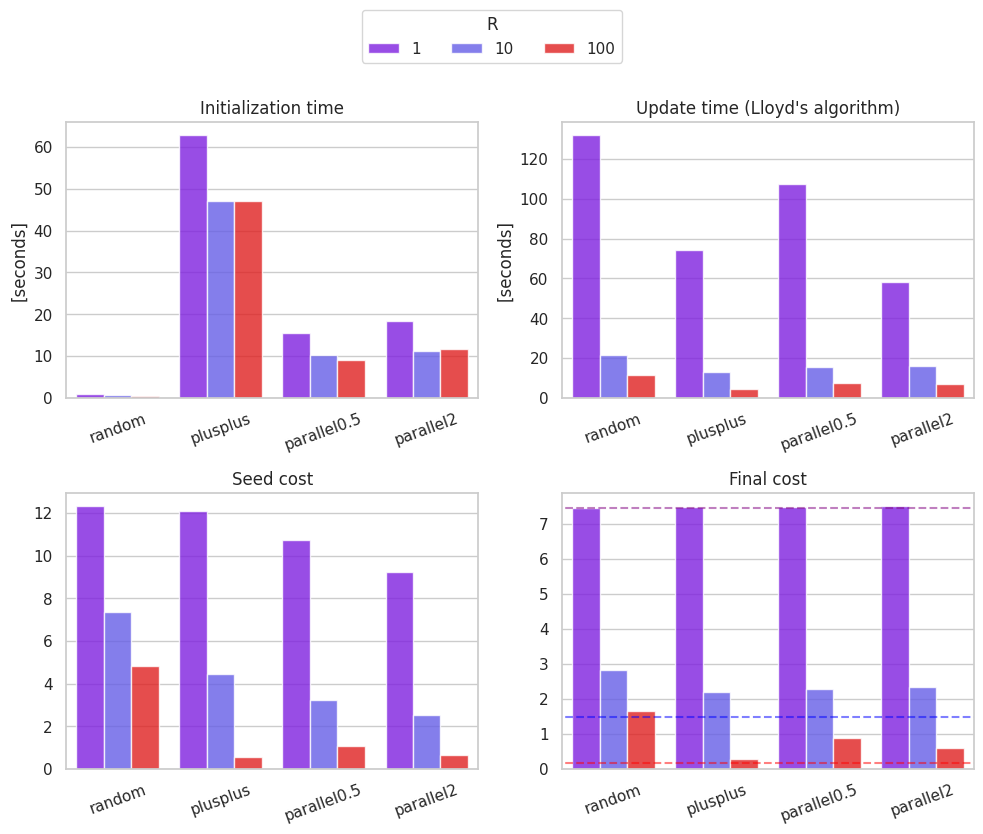

In [ ]:
sns.set_theme(style="whitegrid")
matplotlib.rcParams.update({'font.size': 12})

# Define metrics and titles
metrics = ["initTime", "updateTime", "seedCost", "finalCost"]
units = ["[seconds]", "[seconds]", None, None]
titles = ["Initialization time", "Update time (Lloyd's algorithm)", "Seed cost", "Final cost"]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, metric, title, unit in zip(axs.flat, metrics, titles, units):
    sns.barplot(
        data = initAlgoMetrics,
        x = "initAlgo",
        y = metric,
        hue = "R",
        palette = "rainbow",
        alpha = 0.8,
        ax = ax
    )
    if title == "Final cost":
        ax.hlines(np.unique(initAlgoMetrics["trueCost"]), xmin = -1, xmax = 4, 
                  colors = ["red", "blue", "purple"], linestyle = "--", alpha = 0.5)
    ax.set_title(title)
    ax.set_xlim(-0.5, 3.5)
    ax.set_xlabel(None)
    ax.set_ylabel(unit)
    ax.tick_params(axis="x", rotation=20)
    ax.get_legend().remove() 


# Legend comune in alto
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=len(labels),
    title="R",
    bbox_to_anchor=(0.5, 1.05)  
)

plt.savefig("time_cost_comparison.pdf")
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

## Cost vs. r plots

In [7]:
def collect_costHistory(
    data_rdd: RDD,
    rounds: list[int],
    k: int,
    lk_ratios: list[float],
    iterations: int,
    verbose: bool = False
) -> dict[int, list]:
    costHistory = {}

    for lk_ratio in lk_ratios:
        costHistory[lk_ratio] = []
        for r in rounds:
            if verbose:
                print(f"lk_ratio: {lk_ratio} | rounds: {r}")
            if r==0:
                finalCentroids = kMeansRandom_init(data_rdd, 1)
            else:
                centroids = kMeansParallel_init(data_rdd, k, lk_ratio * k, r)
                finalCentroids = lloydKMeans(data_rdd, centroids, iterations)
            cost = compute_cost(data_rdd, finalCentroids)
            costHistory[lk_ratio].append(cost)
    return costHistory

In [8]:
# --- control parameters --- 

# Actual parameters
lk_ratios = [0.5, 1, 2, 5, 10]
rounds = [0, 1, 2, 4, 8, 16]

In [9]:
### Aggiungi Media

R = [10, 100]
baselineCosts = []
costHistory = {}
for variance in R:
    print(f"R: {variance}")
    gmData, gmCenters = get_gm(n, k, dim, variance)
    gmData_rdd = sc.parallelize([row for row in gmData], numSlices=16).persist()
    trueCost = compute_cost(gmData_rdd, gmCenters)

    # baseline (KM++ seeds + Lloyd)
    print("plusplus")
    centroids = kMeansPlusPlus_init(gmData, k)
    finalCentroids = lloydKMeans(gmData_rdd, centroids, iterations)
    baselineCosts.append(compute_cost(gmData_rdd, finalCentroids))
    
    costHistory[variance] = collect_costHistory(gmData_rdd, rounds, k, lk_ratios, iterations, verbose = True)

R: 10


plusplus


lk_ratio: 0.5 | rounds: 1


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 0.5 | rounds: 8


lk_ratio: 0.5 | rounds: 16


lk_ratio: 1 | rounds: 1


lk_ratio: 1 | rounds: 2


lk_ratio: 1 | rounds: 4


lk_ratio: 1 | rounds: 8


lk_ratio: 1 | rounds: 16


lk_ratio: 2 | rounds: 1


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 2 | rounds: 8


lk_ratio: 2 | rounds: 16


lk_ratio: 5 | rounds: 1


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


lk_ratio: 5 | rounds: 8


lk_ratio: 5 | rounds: 16


lk_ratio: 10 | rounds: 1


lk_ratio: 10 | rounds: 2


lk_ratio: 10 | rounds: 4


lk_ratio: 10 | rounds: 8


lk_ratio: 10 | rounds: 16


R: 100
plusplus


lk_ratio: 0.5 | rounds: 1


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 0.5 | rounds: 8


lk_ratio: 0.5 | rounds: 16


lk_ratio: 1 | rounds: 1


lk_ratio: 1 | rounds: 2


lk_ratio: 1 | rounds: 4


lk_ratio: 1 | rounds: 8


lk_ratio: 1 | rounds: 16


lk_ratio: 2 | rounds: 1


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 2 | rounds: 8


lk_ratio: 2 | rounds: 16


lk_ratio: 5 | rounds: 1


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


lk_ratio: 5 | rounds: 8


lk_ratio: 5 | rounds: 16


lk_ratio: 10 | rounds: 1


lk_ratio: 10 | rounds: 2


lk_ratio: 10 | rounds: 4


lk_ratio: 10 | rounds: 8


lk_ratio: 10 | rounds: 16


In [18]:
def plot_costHistory(
    costHistory: dict[int, dict[int, list]],
    rounds: list[int],
    baselineCosts: list[float]
) -> None:
    matplotlib.rcParams.update({'font.size': 16})
    
    fig, axs = plt.subplots(1, len(costHistory.keys()), figsize=(18, 6))

    for idx, (RR, results) in enumerate(costHistory.items()):
        ax = axs[idx]
        
        ax.hlines(baselineCosts[idx], xmin = rounds[0] - 2, xmax = rounds[-1] + 2, 
                  label = "plusplus", linestyle = "--", alpha = 0.5)
        for lk_ratio in results.keys():
            ax.plot(rounds, results[lk_ratio], label = f"{lk_ratio}",
                    alpha = 0.8)
        
        ax.set_xlim(rounds[0], rounds[-1])
        ax.legend()
    
    plt.show()
    return

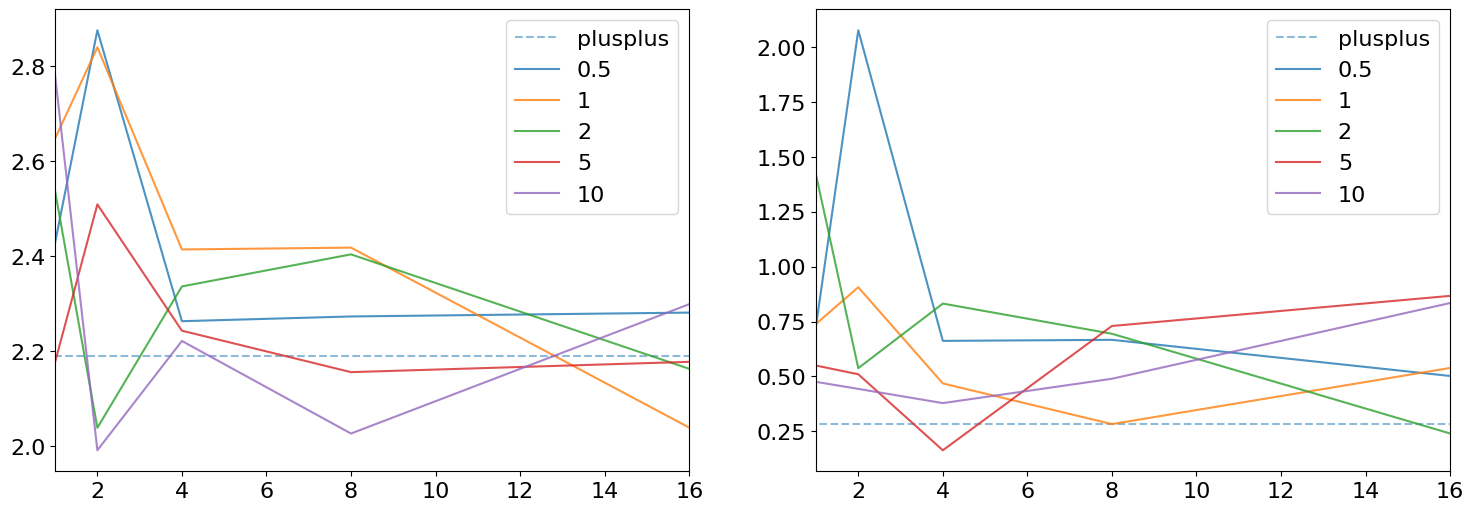

In [19]:
plot_costHistory(costHistory, rounds, baselineCosts)

In [ ]:
def plot_results(
    costHistory: dict[int, list],
    rounds: list[int],
    baselineCost: float
) -> None:
    matplotlib.rcParams.update({'font.size': 16})
    
    fig, axs = plt.subplots(1, len(costHistory.keys()), figsize=(18, 6), sharey=True)

    for idx, (RR, res) in enumerate(costHistory.items()):
        ax = axs[idx]

        curves = res["curves"]
        base = res["base"]
        rounds = res["rounds"]

        # colormap
        lk_values = sorted(curves.keys())
        colors = cm.rainbow(np.linspace(0, 1, len(lk_values)))

        # markers and lines styles
        markers = ["s", "o", "X", "^"]
        lines = ["solid", "dotted", "dashed", "dashdot"]

        for lk, color, marker, line in zip(lk_values, colors, markers, lines):
            phis = curves[lk]
            ax.plot(rounds, phis, marker=marker, markersize=8, markerfacecolor="none", color=color, 
                    linewidth=1.5, linestyle=line, alpha=0.8, label=f"l/k={lk}")

        ax.axhline(base, color="k", lw=1, linestyle="solid", label="KM++ & Lloyd baseline")

        ax.set_title(f"R = {RR}", fontsize=16)
        ax.set_xlabel("# Initialization Rounds")
        if idx == 0:
            ax.set_ylabel("Cost (~$10^{\\alpha}$)")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(frameon=False)

    plt.savefig("lk_plot.pdf")
    plt.tight_layout()
    plt.show()

In [ ]:
### cost(KDD)/time vs. l - fixed r

# Update analysis

In [6]:
kddData, kddLabels, entries_dict = get_kdd(standardize=True)

In [8]:
k = np.unique(kddLabels).shape[0]
l = 0.5 * k

In [9]:
kddData_rdd = sc.parallelize([row for row in kddData]).persist()
centroids = kMeansParallel_init(kddData_rdd, k, l)
kddData_rdd.unpersist()

ParallelCollectionRDD[1] at readRDDFromFile at PythonRDD.scala:289

In [9]:
time_dict = {}

Lloyd's kMeans serial

In [13]:
iterations = 10
startTime = time.time()
seedCentroids = centroids.copy()
finalCentroids = lloydKMeans(kddData, seedCentroids, iterations, earlyStopping=False)
deltaTime = time.time() - startTime
time_dict[1] = {"lloyd": deltaTime}

Parallel

In [ ]:
partitions = [2, 4, 8, 16, 32, 64, 128]
for numSlices in partitions:
    time_dict[numSlices] = {}
    kddData_rdd = sc.parallelize([row for row in kddData], numSlices=numSlices).persist()
    
    startTime = time.time()
    seedCentroids = centroids.copy()
    finalCentroids = lloydKMeans(kddData_rdd, seedCentroids, iterations, earlyStopping=False)
    deltaTime = time.time() - startTime
    time_dict[numSlices]["lloyd"] = deltaTime

    startTime = time.time()
    seedCentroids = centroids.copy()
    finalCentroids = miniBatchKMeans(kddData_rdd, seedCentroids, iterations, earlyStopping=False)
    deltaTime = time.time() - startTime
    time_dict[numSlices]["miniBatch"] = deltaTime
    
    kddData_rdd.unpersist()

In [14]:
time_dict

{1: {'lloyd': 17.238966464996338},
 2: {'lloyd': 34.04286217689514, 'miniBatch': 12.04980731010437},
 4: {'lloyd': 17.933119535446167, 'miniBatch': 8.075101613998413},
 8: {'lloyd': 10.722455978393555, 'miniBatch': 5.795122861862183},
 16: {'lloyd': 8.191429376602173, 'miniBatch': 5.853504419326782},
 32: {'lloyd': 10.909662961959839, 'miniBatch': 6.993889093399048},
 64: {'lloyd': 12.047245025634766, 'miniBatch': 9.350556135177612},
 128: {'lloyd': 17.013242483139038, 'miniBatch': 13.624184846878052}}

In [ ]:
### Plottare overhead per npartitions (lloyd/mini-batch)

### Cost vs iterations


We now want to study, for each version of the algorithm, the number of iterations required to obtain an optimal solution. To do this, we track the cost function values at each iteration:

In [ ]:
kddData_rdd = sc.parallelize([row for row in kddData], numSlices=16).persist()
iterations = 100
updateAlgorithms = ["lloyd", "lloyd", "miniBatch", "miniBatch", "miniBatch", "miniBatch"]
batchFractions = ["serial", "parallel", 0.001, 0.01, 0.1, 0.5]

results_dict = {}

seedCost = compute_cost(kddData_rdd, centroids)

# n_runs = 3  # number of independent runs
for updateAlgo, batchFraction in zip(updateAlgorithms, batchFractions):
    print(f"{updateAlgo}_{batchFraction}")
    seedCentroids = centroids.copy()

    if updateAlgo == "lloyd":
        if batchFraction == "serial":
            finalCentroids, costHistory = lloydKMeans(kddData, seedCentroids, iterations, save_cost = True)
        else:
            finalCentroids, costHistory = lloydKMeans(kddData_rdd, seedCentroids, iterations, save_cost = True)
    else:
        finalCentroids, costHistory = miniBatchKMeans(kddData_rdd, seedCentroids, iterations, batchFraction, save_cost = True)

    results_dict[f"{updateAlgo}_{batchFraction}"] = costHistory
kddData_rdd.unpersist()

ParallelCollectionRDD[57] at readRDDFromFile at PythonRDD.scala:289

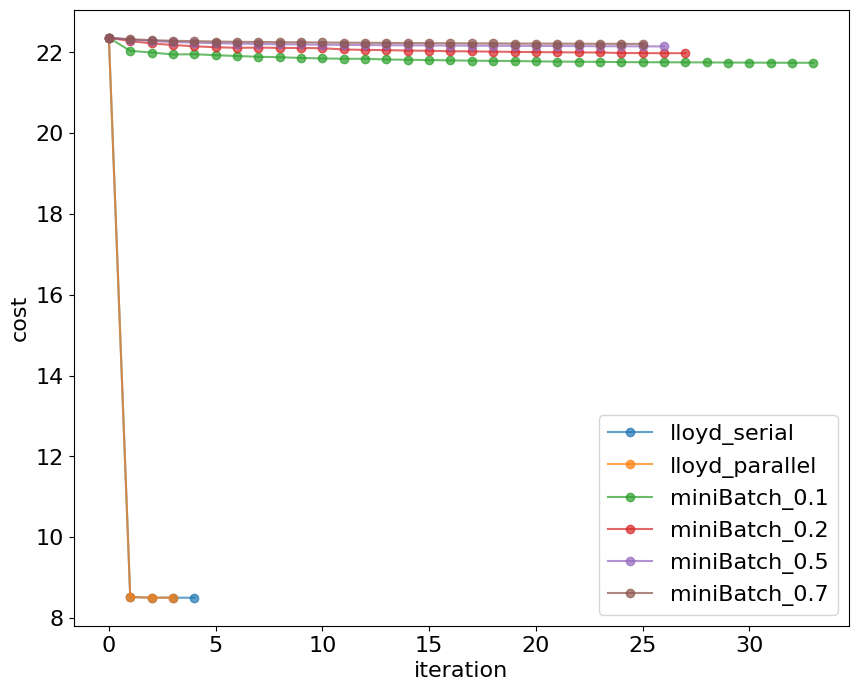

In [ ]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,8))

for key, costHistory in results_dict.items():
    ax.plot([seedCost] + costHistory, marker="o", label = key, alpha = 0.7)

ax.set_title("Cost vs iterations")
ax.set_xlabel("iteration")
ax.set_ylabel("cost")
ax.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# different markers
markers = ['o', 's', '^', 'D', 'x', '*']

# offsets to avoid errorbar overlaps
offsets = [0,1,0,0,1,-1]
for i, (key, stats) in enumerate(results_mean_std.items()):
    mean = stats["mean"]
    std = stats["std"]
    epochs = np.arange(len(mean))

    # line style
    if "lloyd" in key:
        line_style = "--"   
    else:
        line_style = "-"    

    # cycle markers
    marker = markers[i]
    
    plt.errorbar(
        epochs[::10+offsets[i]], mean[::10+offsets[i]], yerr=std[::10+offsets[i]],
        fmt=line_style+marker, capsize=3, label=key
    )
    offset += 1

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.title("K-Means Convergence: Cost vs Epochs", fontsize=16)
plt.grid(alpha=0.6)
plt.legend(title="Algorithm:", loc="best")
plt.show()

In [ ]:
### WHY costo minore = batch fraction minore

From the plot above, we observe an interesting pattern: although the serial and parallel K-means algorithms require fewer iterations to reach convergence, they also demand more execution time. In contrast, the minibatch version requires more iterations to converge but achieves a lower overall execution time.

Another interesting observation is that better solutions for the minibatch algorithm, in terms of minimizing the cost function, are obtained when using smaller batch fractions.  
This can be explained by the formula used to update a generic centroid $j$:

$$
c_j^{(t+1)} = (1 - \eta_t) \, c_j^{(t)} + \eta_t \, \bar{x}_j^{(t)}
$$

where $\eta_t$ is the learning rate used for the update of centroid $j$ at iteration $t$.  
The learning rate is proportional to $\frac{1}{N_j^{\text{samples}}}$, where $N_j^{\text{samples}}$ is the total number of points assigned to cluster $j$ since the beginning of the algorithm.  

From this formula, we see that larger batch fractions result in a faster increase of $N_j^{\text{samples}}$, which in turn reduces the learning rate more quickly.  
Consequently, the centroid updates become smaller over time, potentially leading to slower convergence and poorer minimization of the cost function. Note that the parallel K-means update formula can be recovered from the expression above by setting the learning rate to a constant value of 1.

Stopping the cluster

In [15]:
sc.stop()
spark.stop()

In [16]:
# stopping the cluster
! $SPARK_HOME/sbin/stop-all.sh
# clearing the `$SPARK_HOME/work` directory in all the nodes
# this avoids cluttering of storage among nodes
! rm -rf $SPARK_HOME/work/*
! ssh worker1 "rm -rf $SPARK_HOME/work/*"
! ssh worker2 "rm -rf $SPARK_HOME/work/*"
! ssh worker3 "rm -rf $SPARK_HOME/work/*"

worker3: stopping org.apache.spark.deploy.worker.Worker
worker1: stopping org.apache.spark.deploy.worker.Worker
worker2: stopping org.apache.spark.deploy.worker.Worker
master: stopping org.apache.spark.deploy.worker.Worker
stopping org.apache.spark.deploy.master.Master
